In [1]:
from raw_python.Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from raw_python.BaggingSA import BaggingSA
from typing import Literal, Tuple
from raw_python.Bagging import predict
import sklearn
from raw_python.plots_manager import *
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from tabulate import tabulate


# PARAMS

+---------+-------+------+-------+----------+---------------+---------------+
| dataset | theta | beta | gamma | accuracy | fitness_ratio | spearman_corr |
+---------+-------+------+-------+----------+---------------+---------------+
| digits  | 0.25  | 0.75 | 0.25  |  0.934   |     0.366     |     0.249     |
|  wine   | 0.25  | 0.25 |  1.0  |  0.961   |     0.174     |     0.084     |
+---------+-------+------+-------+----------+---------------+---------------+


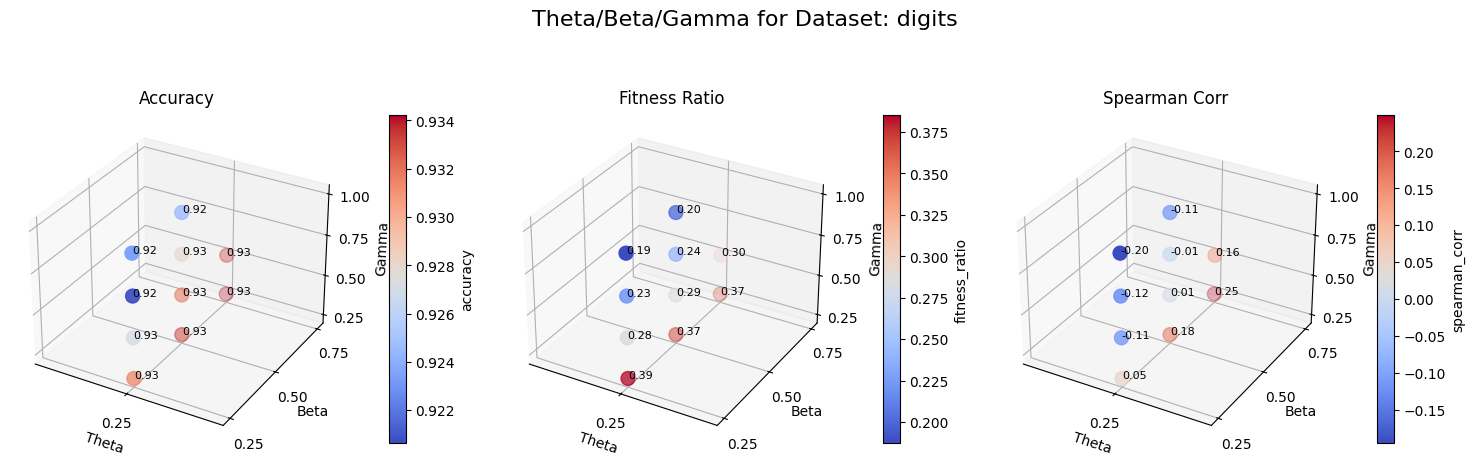

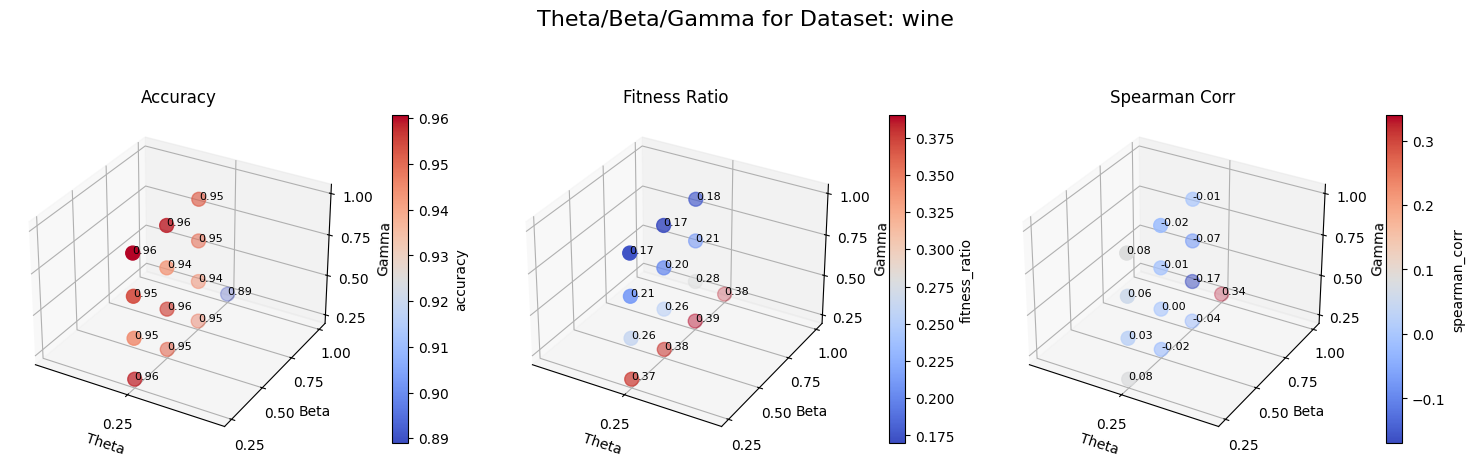

In [2]:
files = glob.glob('./../res/bagging_sa_params_*.csv')
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

df['fitness_ratio'] = df['fitness'] / (df['theta'] + df['beta'] + df['gamma'])

grouped = df.groupby(['dataset', 'theta', 'beta', 'gamma']).agg({
    'accuracy': 'mean',
    'fitness_ratio': 'mean',
    'spearman_corr': 'mean'
}).reset_index()

grouped_corr = df[df['spearman_p'] < 0.05].groupby(['dataset', 'theta', 'beta', 'gamma']).agg({
    'accuracy': 'mean',
    'fitness_ratio': 'mean',
    'spearman_corr': 'mean'
}).reset_index()


best_by_dataset = grouped.loc[grouped.groupby('dataset')['accuracy'].idxmax()]
tmp = best_by_dataset.copy().round(3)
print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))


# 3D Scatter Plot Function
def plot_metrics_3d_subplots(df, dataset, metrics, titles, themes):
    fig = plt.figure(figsize=(15, 5))  # Adjust figure size for subplots
    fig.suptitle(f"Theta/Beta/Gamma for Dataset: {dataset}", fontsize=16, x=0.5)
    for i, (metric, title, theme) in enumerate(zip(metrics, titles, themes), start=1):
        df_tmp = df[df['dataset'] == dataset]
        ax = fig.add_subplot(1, 3, i, projection='3d')  # Create a subplot for each metric
        sc = ax.scatter(df_tmp['theta'], df_tmp['beta'], df_tmp['gamma'], c=df_tmp[metric], cmap=theme, s=100)
        ax.set_xlabel('Theta')
        ax.set_ylabel('Beta')
        ax.set_zlabel('Gamma')
        ax.set_title(title)
        
        ax.set_xticks(df_tmp['theta'].unique())
        ax.set_yticks(df_tmp['beta'].unique())
        ax.set_zticks(df_tmp['gamma'].unique())
        
        # Adjust colorbar position and size
        cbar = fig.colorbar(sc, ax=ax, shrink=0.8, pad=0.1)  # Shrink and add padding
        cbar.set_label(metric)
        
        # Add numeric annotations
        for _, row in df_tmp.iterrows():
            ax.text(row['theta'], row['beta'], row['gamma'], f"{row[metric]:.2f}", fontsize=8, color='black')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
    plt.show()

datasets = grouped['dataset'].unique()

# Define metrics, titles, and themes for the subplots
metrics = ['accuracy', 'fitness_ratio', 'spearman_corr']
titles = [
    'Accuracy',
    'Fitness Ratio',
    'Spearman Corr'
]
themes = ['coolwarm', 'coolwarm', 'coolwarm']

# Generate subplots for each dataset
for dataset in datasets:
    plot_metrics_3d_subplots(grouped, dataset, metrics, titles, themes)

In [3]:
# # Optionally average over replicates
# grouped = df.groupby(['theta', 'beta', 'gamma']).agg({
#     'accuracy': 'mean',
#     'fitness': 'mean',
#     'spearman_corr': 'mean'
# }).reset_index()

# # Define a function to plot 3D scatter
# def plot_3d_metric(data, metric, title):
#     fig = px.scatter_3d(
#         data, x='theta', y='beta', z='gamma',
#         color=metric, size_max=10,
#         title=title,
#         color_continuous_scale='Viridis',
#         labels={'theta': 'Theta', 'beta': 'Beta', 'gamma': 'Gamma'}
#     )
#     fig.update_traces(marker=dict(size=5))
#     fig.show()

# # Create interactive 3D plots
# plot_3d_metric(grouped, 'accuracy', 'Accuracy vs Theta/Beta/Gamma')
# plot_3d_metric(grouped, 'fitness', 'Fitness vs Theta/Beta/Gamma')
# plot_3d_metric(grouped, 'spearman_corr', 'Spearman Correlation vs Theta/Beta/Gamma')

# RESULT COMPARISON PLOTS  

In [4]:
def create_comparison_plot(df: pd.DataFrame) -> None:
    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
    plt.figure(figsize=(12, 4))
    
    X = df['nTrees'].unique()
    dataset_name = df['Dataset'].values[0]
    
    y_data=[
        # ("DT", "Decision tree"),
        ("Bagging", "Bagging"),
        ("BaggingCustom", "Bagging custom"),
        # ("RF", "Random forrest"),
        ("BaggingSA", "Bagging SA")
    ]

    for df_name, plt_name in y_data:
        Y, Y_std = df[df_name], df[df_name + "_STD"]
        plt.plot(X, Y, marker='o', label=plt_name)
        plt.fill_between(X, Y - Y_std, Y + Y_std, alpha=0.2)

    plt.title(f"Accuracy per trees amount for dataset: {dataset_name}")
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(X)
    plt.grid()
    
    plt.show()
    
    

+---------------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+
|    Dataset    | nTrees |  DT   | Bagging |  RF   | BaggingCustom | BaggingSA | DT_STD | Bagging_STD | RF_STD | BaggingCustom_STD | BaggingSA_STD |
+---------------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+
| breast_cancer |   10   | 0.921 |  0.953  | 0.946 |     0.947     |   0.944   | 0.032  |    0.009    | 0.015  |       0.017       |     0.013     |
| breast_cancer |   20   | 0.922 |  0.958  | 0.954 |     0.954     |   0.954   | 0.029  |    0.018    | 0.016  |       0.012       |     0.013     |
| breast_cancer |   30   | 0.929 |  0.963  | 0.953 |     0.958     |   0.953   | 0.019  |    0.01     | 0.017  |       0.014       |     0.011     |
| breast_cancer |   40   | 0.919 |  0.968  | 0.961 |     0.96      |   0.959   | 0.031  |    0.015    | 0.

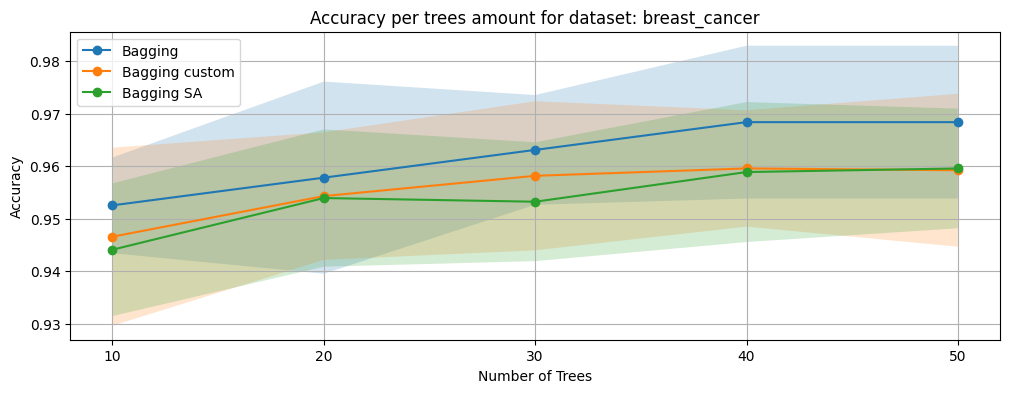


+---------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+
| Dataset | nTrees |  DT   | Bagging |  RF   | BaggingCustom | BaggingSA | DT_STD | Bagging_STD | RF_STD | BaggingCustom_STD | BaggingSA_STD |
+---------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+
| digits  |   10   | 0.86  |  0.928  | 0.949 |     0.927     |   0.932   | 0.016  |    0.015    | 0.008  |       0.021       |     0.015     |
| digits  |   20   | 0.858 |  0.937  | 0.965 |     0.934     |   0.948   | 0.017  |    0.014    | 0.009  |       0.016       |     0.013     |
| digits  |   30   | 0.858 |  0.944  | 0.97  |     0.942     |   0.947   | 0.018  |    0.017    | 0.009  |       0.012       |     0.012     |
| digits  |   40   | 0.861 |  0.945  | 0.973 |     0.941     |   0.952   | 0.016  |    0.014    | 0.007  |       0.013       |     0.012     

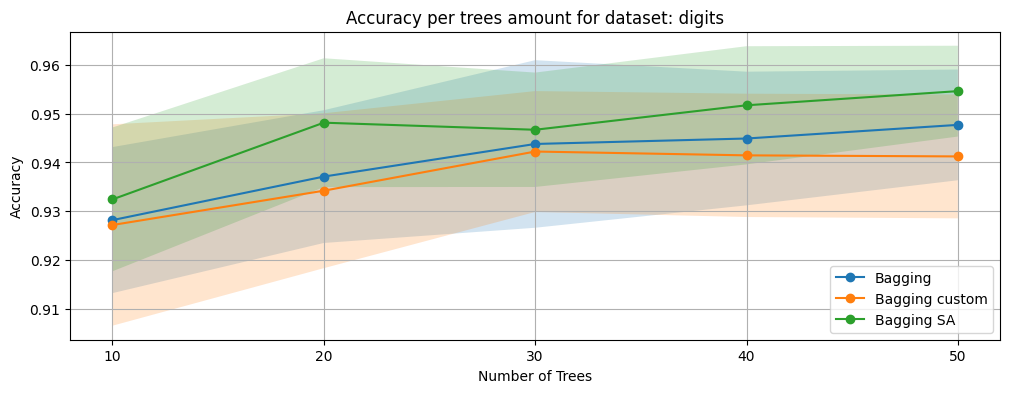


+---------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+
| Dataset | nTrees |  DT   | Bagging |  RF   | BaggingCustom | BaggingSA | DT_STD | Bagging_STD | RF_STD | BaggingCustom_STD | BaggingSA_STD |
+---------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+
|  pima   |   10   | 0.699 |  0.746  | 0.738 |     0.743     |   0.724   | 0.019  |    0.016    | 0.009  |       0.018       |     0.026     |
|  pima   |   20   | 0.698 |  0.76   | 0.763 |     0.757     |   0.744   | 0.017  |    0.015    | 0.023  |       0.023       |     0.027     |
|  pima   |   30   | 0.701 |  0.762  | 0.768 |     0.755     |   0.751   | 0.016  |    0.019    | 0.013  |       0.022       |     0.021     |
|  pima   |   40   | 0.697 |  0.77   | 0.769 |     0.75      |   0.752   | 0.022  |    0.017    | 0.014  |       0.02        |     0.018     

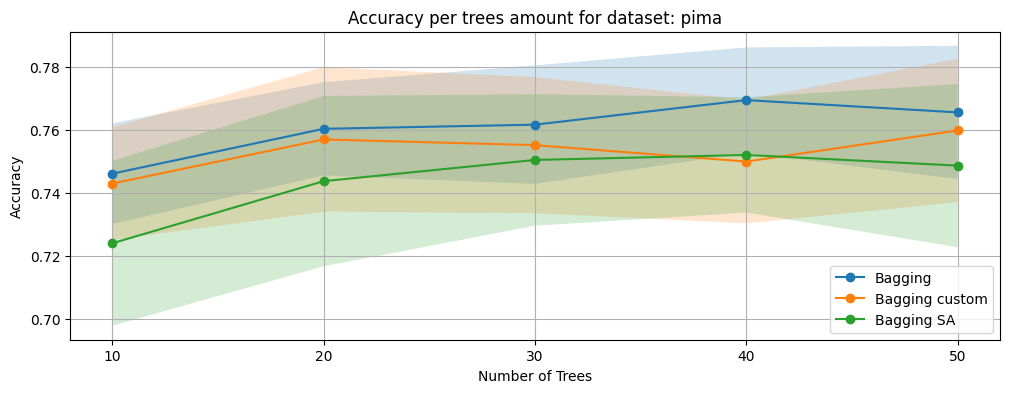


+---------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+
| Dataset | nTrees |  DT   | Bagging |  RF   | BaggingCustom | BaggingSA | DT_STD | Bagging_STD | RF_STD | BaggingCustom_STD | BaggingSA_STD |
+---------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+
|  wine   |   10   | 0.885 |  0.972  | 0.978 |     0.956     |   0.951   | 0.049  |    0.031    | 0.021  |       0.045       |     0.038     |
|  wine   |   20   | 0.88  |  0.967  | 0.983 |     0.965     |   0.971   | 0.045  |    0.028    | 0.023  |       0.035       |     0.028     |
|  wine   |   30   | 0.892 |  0.972  | 0.983 |     0.964     |   0.979   | 0.044  |    0.031    | 0.023  |       0.031       |     0.023     |
|  wine   |   40   | 0.878 |  0.978  | 0.983 |     0.966     |   0.965   | 0.052  |    0.021    | 0.023  |       0.031       |     0.031     

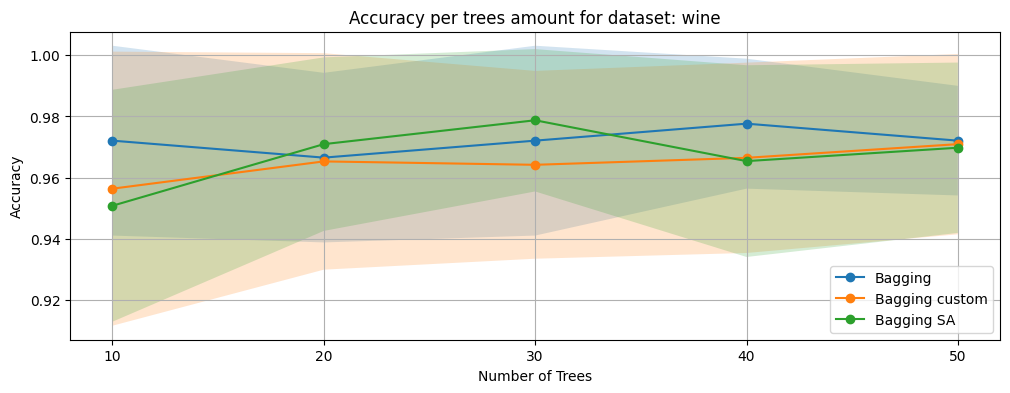

In [5]:
from tabulate import tabulate


files = glob.glob('./../res/accuracy_comparison_*.csv')
dfs = [pd.read_csv(f) for f in files]

for df in dfs:
    df_aggregated = df.groupby(['nTrees']).agg(
        Dataset=('Dataset', 'first'),
        nTrees=('nTrees', 'first'),
        
        DT=('DT', 'mean'),
        Bagging=('Bagging', 'mean'),
        RF=('RF', 'mean'),
        BaggingCustom=('BaggingCustom', 'mean'),
        BaggingSA=('BaggingSA', 'mean'),

        DT_STD=('DT','std'),
        Bagging_STD=('Bagging','std'),
        RF_STD=('RF','std'),
        BaggingCustom_STD=('BaggingCustom','std'),
        BaggingSA_STD=('BaggingSA','std'),
    ).reset_index(drop=True).dropna()
    
    tmp = df_aggregated.copy().round(3)
    print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))
    create_comparison_plot(df_aggregated)
    print()
    
    